# EDA

In [1]:
import os
import pandas as pd
import numpy as np
import constants as ct
from kaggletoxicity.utils import get_upper_case_prop, get_punctuation_prop, process_text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
from tqdm import tqdm
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.width = 1000
pd.options.display.max_colwidth = 200

X_train = pd.read_hdf(ct.STORE_PATH, 'X_train')
Y_train = pd.read_hdf(ct.STORE_PATH, 'Y_train')
X_full = pd.read_hdf(ct.STORE_PATH, 'X_full')
flame_example = pd.read_hdf(ct.STORE_PATH, 'flame_example')

Using TensorFlow backend.


In [2]:
Y_train.sum().div(Y_train.shape[0] / 100).sort_values(ascending=False)

toxic            9.584448
obscene          5.294822
insult           4.936361
severe_toxic     0.999555
identity_hate    0.880486
threat           0.299553
dtype: float64

## Longitud de comentarios

In [3]:
# X_full.comment_text.map(lambda s:)
len_comments = X_full.comment_text.str.len()
len_comments.name = 'comment_len'
len_comments.describe()

count    312735.000000
mean        379.773262
std         591.767791
min           1.000000
25%          87.000000
50%         193.000000
75%         414.000000
max        5000.000000
Name: comment_len, dtype: float64

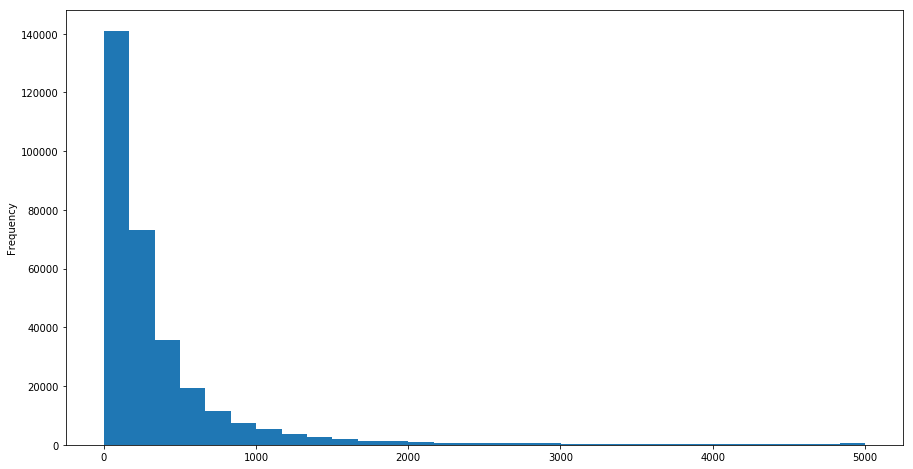

In [4]:
len_comments.plot(kind="hist", bins=30, figsize=(15, 8));

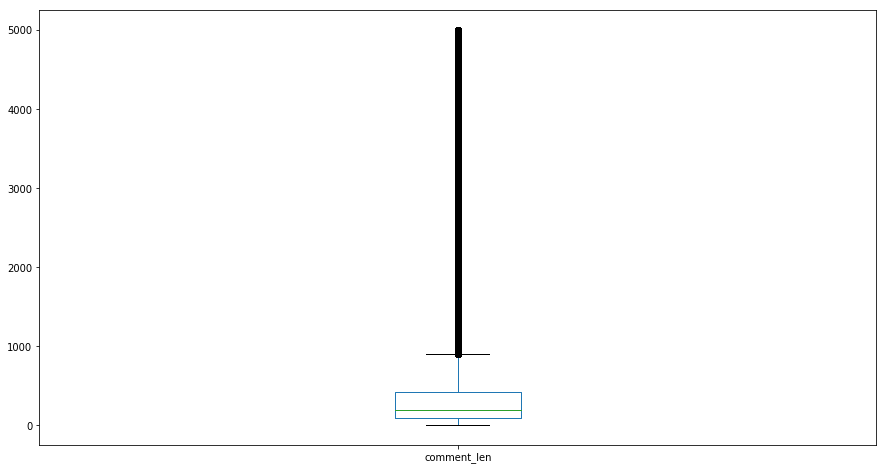

In [5]:
len_comments.plot(kind="box", figsize=(15, 8));

In [6]:
len_comments.quantile(np.linspace(0, 1, 21))

0.00       1.0
0.05      30.0
0.10      42.0
0.15      55.0
0.20      71.0
0.25      87.0
0.30     105.0
0.35     124.0
0.40     145.0
0.45     167.0
0.50     193.0
0.55     224.0
0.60     260.0
0.65     301.0
0.70     350.0
0.75     414.0
0.80     502.0
0.85     630.0
0.90     848.0
0.95    1314.0
1.00    5000.0
Name: comment_len, dtype: float64

In [7]:
X_train.comment_text.isnull().sum()

0

## Estudiamos la longitud de los comentarios respecto a las categorías

In [8]:
train_df = pd.concat([len_comments.loc[Y_train.index], X_train, Y_train], axis=1)
train_df.head()

,comment_len,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,,
0000997932d777bf,264,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0,0,0,0,0,0
000103f0d9cfb60f,112,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,233,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0,0,0,0,0,0
0001b41b1c6bb37e,622,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0,0,0,0,0,0
0001d958c54c6e35,67,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


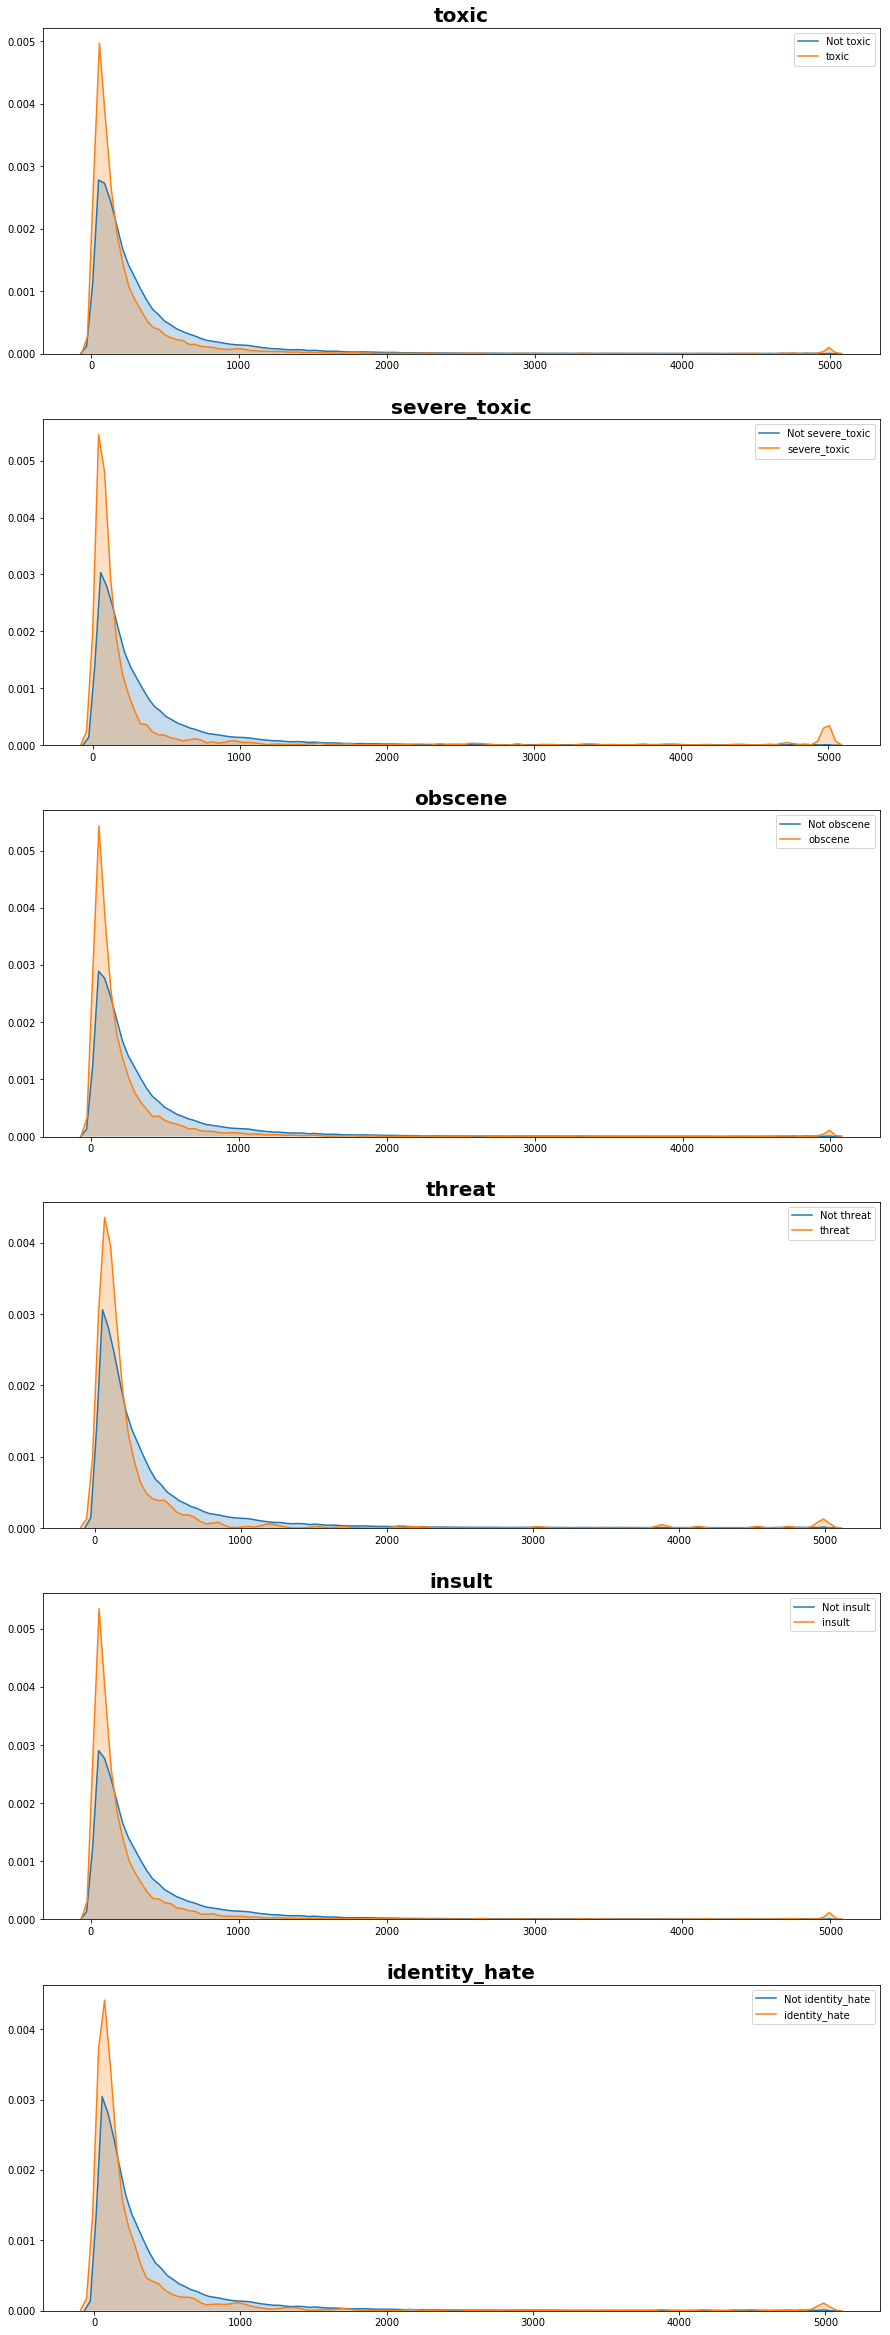

In [9]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(15, 7 * 6 ))

axs_arr = axs.ravel()

for i, plot_ax in enumerate(axs_arr):
    col = ct.OBJECTIVE_COLS[i]
    not_bad_Data = train_df.loc[train_df[col] == 0].comment_len
    bad_Data = train_df.loc[train_df[col] == 1].comment_len
    
    sns.kdeplot(not_bad_Data, shade=True, ax=plot_ax, legend='non %s' % col)
    sns.kdeplot(bad_Data, shade=True, ax=plot_ax, legend='%s' % col)    
    plot_ax.legend(['Not %s' % col, col]);
    plot_ax.set_title(col, fontsize=20, fontweight='bold')

## Comentarios muy cortos

In [10]:
print(X_full.loc[len_comments < 10].comment_text.size)
X_full.loc[len_comments < 10].comment_text

163


id
8c4c53001134f290        14:53,
4c5cde3ab1a618c9      {{unbloc
7b3d18857df782cf      FUCK YOU
87c06f935f2c6559      you suck
dd5ac2c49ec34efa        ~ J.Lo
00a07ba2a7e7ea19        :Great
0118f7ea375be714      :Me too!
014c2d8307d7ed7b     D. Hinmon
023dc1963b20ac98       Fck you
02e7d85840791b1f       :Agree.
08c850caa00a88d6       Concur.
0a4b81ea14e41896      K NIGRA!
0af7effe1fd4b873             '
133b85d507169a8b     :: Okay !
1aaa1fb0d8f77423      Emotions
1c105220d7afed01           Fag
1e6a4ff712ff7588       :My fav
1e7f2afccb89d49b     == ISL ==
200c99803eb470d0      removed.
21e7ba777bb4948e      FUCK OFF
259b63f4c3e621dd     July 2008
25a506a7a4be7e7c      == Hi ==
26ee71963e1dbcc6     = history
2984c7a4e35273e1       kill it
2a2aba834515da83     :Thanks !
2a9605630ea2d2e4     FUCK 0FF.
2cb468fb9184cef2      Dec 2005
2fd7a0607b4e0260       Agreed.
3119a4f4e2888b36        PENIS.
317a5afa3e6a3c21     :: Right.
33340b0875519202     Air flow.
3431567461b9e6e6        Shame!
34471

## Asociación entre etiquetas

In [11]:
implications = pd.DataFrame(np.nan, index=Y_train.columns, columns=Y_train.columns)

for col_ant in Y_train.columns:
    for col_con in Y_train.columns:
        
        selection_df = Y_train.loc[Y_train[col_ant] == 1]
        n_ant = selection_df.shape[0]
        n_con = selection_df[col_con].sum()
        implications.loc[col_ant, col_con] = n_con / n_ant
        
implications

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.104289,0.518242,0.029358,0.480188,0.085131
severe_toxic,1.000000,1.000000,0.951097,0.070219,0.859561,0.196238
obscene,0.938099,0.179548,1.000000,0.035626,0.728489,0.122145
threat,0.939331,0.234310,0.629707,1.000000,0.642259,0.205021
insult,0.932335,0.174051,0.781389,0.038974,1.000000,0.147264
identity_hate,0.926690,0.222776,0.734520,0.069751,0.825623,1.000000


In [12]:
frequent_itemsets = apriori(Y_train, min_support=1e-6, use_colnames=True)

In [13]:
frequent_itemsets.head(20)

,support,itemsets
0,0.095844,[toxic]
1,0.009996,[severe_toxic]
2,0.052948,[obscene]
3,0.002996,[threat]
4,0.049364,[insult]
5,0.008805,[identity_hate]
6,0.009996,"[toxic, severe_toxic]"
7,0.049671,"[toxic, obscene]"
8,0.002814,"[toxic, threat]"
9,0.046023,"[toxic, insult]"


In [14]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

In [15]:
rules['n_elements'] = rules.support.mul(Y_train.shape[0])
rules.sort_values(by=['confidence', 'n_elements'], ascending=[False, False], inplace=True)

In [16]:
Y_train.shape

(159571, 6)

In [17]:
rules.head(50)

,antecedants,consequents,support,confidence,lift,n_elements
72,(severe_toxic),(toxic),0.009996,1.000000,10.433569,1595.0
219,"(obscene, severe_toxic)",(toxic),0.009507,1.000000,10.433569,1517.0
197,"(insult, severe_toxic)",(toxic),0.008592,1.000000,10.433569,1371.0
190,"(insult, obscene, severe_toxic)",(toxic),0.008454,1.000000,10.433569,1349.0
81,"(identity_hate, severe_toxic)",(toxic),0.001962,1.000000,10.433569,313.0
52,"(identity_hate, severe_toxic, insult)",(toxic),0.001899,1.000000,10.433569,303.0
12,"(identity_hate, obscene, severe_toxic)",(toxic),0.001893,1.000000,10.433569,302.0
20,"(identity_hate, obscene, severe_toxic, insult)",(toxic),0.001855,1.000000,10.433569,296.0
134,"(threat, severe_toxic)",(toxic),0.000702,1.000000,10.433569,112.0
259,"(obscene, threat, severe_toxic)",(toxic),0.000620,1.000000,10.433569,99.0


## Contar palabras únicas en comentarios limpios

In [32]:
clean_comments = X_train.loc[Y_train.sum(axis=1) == 0].comment_text
clean_comments_unique_word_count = clean_comments.map(lambda s:len(set(s.lower().split(' '))))
clean_comments_unique_word_count

id
0000997932d777bf     40
000103f0d9cfb60f     18
000113f07ec002fd     39
0001b41b1c6bb37e     82
0001d958c54c6e35     13
00025465d4725e87     12
00031b1e95af7921     21
00037261f536c51d     69
00040093b2687caa     12
0005300084f90edc    217
00054a5e18b50dd4     11
0006f16e4e9f292e    107
00070ef96486d6f9     31
00078f8ce7eb276d     90
000897889268bc93      5
0009801bd85e5806     19
0009eaea3325de8c     61
000b08c464718505     39
000bfd0867774845     10
000c0dfd995809fa     69
000c6a3f0cd3ba8e     16
000cfee90f50d471    158
000eefc67a2c930f     20
000f35deef84dc4a     41
000ffab30195c5e1     53
0010307a3a50a353     26
0010833a96e1f886     15
0011cc71398479c4     17
00128363e367d703     13
001325b8b20ea8aa     12
001363e1dbe91225     87
0013a8b1a5f26bcb     48
00148d055a169b93     92
00151a9f93c6b059    141
0015f4aa35ebe9b5     50
00169857adbc989b     25
0016e01b742b8da3    119
001735f961a23fc4     37
00173958f46763a2     28
001b2dd65d9d925c    100
001c419c445b5a59     12
001c557175094

In [18]:
for text in flame_example.comment_text.head(50):
    
    print('*' * 120)
    print(text)
    print('\n')
    print(process_text(text, stem_words=False, remove_stop_words=False))
    print('-' * 120)
    print('\n \n')

************************************************************************************************************************
Nitpicking
If someone is complaining about something stupid, just ignore them. -


nitpicking if someone is complaining about something stupid just ignore them  
------------------------------------------------------------------------------------------------------------------------

 

************************************************************************************************************************
What the fuck is wrong with you? You say I am a fucking vandal and I havn't done anything. Your bot is fucked up.


what the fuck is wrong with you you say i am a fucking vandal and i have not done anything your bot is fucked up 
------------------------------------------------------------------------------------------------------------------------

 

********************************************************************************************************************

In [19]:
train_df['contains_die'] = train_df.comment_text.str.contains('die')
train_df['contains_kill'] = train_df.comment_text.str.contains('kill')

In [20]:
print(train_df.groupby('threat').contains_die.mean())
print(train_df.groupby('threat').contains_kill.mean())

threat
0    0.020843
1    0.200837
Name: contains_die, dtype: float64
threat
0    0.010906
1    0.209205
Name: contains_kill, dtype: float64


In [21]:
print(train_df.groupby('toxic').contains_die.mean())
print(train_df.groupby('toxic').contains_kill.mean())

toxic
0    0.020766
1    0.027200
Name: contains_die, dtype: float64
toxic
0    0.010327
1    0.022558
Name: contains_kill, dtype: float64


In [22]:
print(train_df.groupby('severe_toxic').contains_die.mean())
print(train_df.groupby('severe_toxic').contains_kill.mean())

severe_toxic
0    0.021199
1    0.039498
Name: contains_die, dtype: float64
severe_toxic
0    0.011369
1    0.024451
Name: contains_kill, dtype: float64


In [23]:
print(train_df.groupby('insult').contains_die.mean())
print(train_df.groupby('insult').contains_kill.mean())

insult
0    0.020904
1    0.030595
Name: contains_die, dtype: float64
insult
0    0.010996
1    0.021201
Name: contains_kill, dtype: float64


In [24]:
train_df.groupby('contains_die')[ct.OBJECTIVE_COLS].mean()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
contains_die,,,,,,
False,0.095275,0.009811,0.052498,0.002446,0.048899,0.008658
True,0.121923,0.018464,0.073564,0.028136,0.070633,0.015533
